In [26]:
%aimport lib
%load_ext autoreload
%autoreload 1

import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
dataset = load("IV")

[0.00827504 7.77798104 0.08229175]


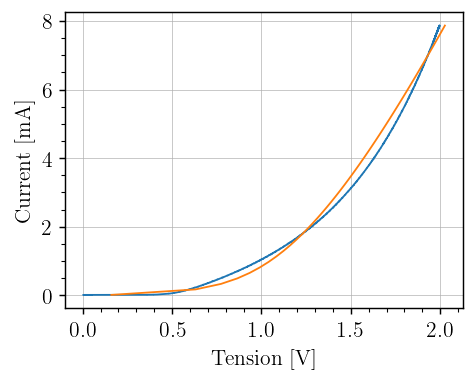

In [31]:
for data in dataset:
    plot_IV(data)
    params, cov = sc.optimize.curve_fit(lambda I, I_s, n, R : curve_IV(I, data.temperature, I_s, n, R), 
                                        data.I, data.V,
                                        p0=(1,1,1),
                                        bounds=(0, np.inf)
                                        )
    print(params)
    x = np.linspace(data.I.min(), data.I.max())
    plt.plot(curve_IV(x, 300, *params), x)                                 
    